In [26]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Load and format raw data

We start by loading the raw data from the edf file. However, when we use print(raw.ch_names) we can see that the channel names contain a dot (e.g. "F7."). We remove the dot from the channel names by renaming the channels. We then pick the desired channels and define the channel positions according to the 10-20 system. We create a new montage with the channel positions and set the montage to the raw data.

# 10-20 system and channels
![image info](./images/10_20_system.PNG)


In [27]:
def load_and_format_raw_data(file_path, desired_channels):
    # load the edf file with mne
    raw = mne.io.read_raw_edf(file_path, preload=True)

    print(raw.ch_names)

    # rename channels without "." (dot) in the name
    new_ch_names = {ch_name: ch_name.replace('.', '') for ch_name in raw.info['ch_names']}
    raw.rename_channels(new_ch_names)

    # pick desired channels
    raw.pick_channels(desired_channels)

    # define channel positions (10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    positions = {ch: montage.get_positions()['ch_pos'][ch] for ch in desired_channels}

    # create new montage with the channel positions
    new_montage = mne.channels.make_dig_montage(positions, coord_frame='head')

    # set montage
    raw.set_montage(new_montage)

    return raw

file_path = "sampleData/S001R04.edf"

# define list of desired channels (10-20 system; desired channels are the 14 emotiv epoc channels, but there are only 10 of them in the dataset)
desired_channels = ["F7", "F3", "T7", "P7", "O1", "O2", "P8", "T8", "F4", "F8"]

raw = load_and_format_raw_data(file_path, desired_channels)


# Load and format raw data

# we start by loading the raw data from the edf file. However, when we use print(raw.ch_names) we can see that the channel names contain a dot (e.g. "F7."). We remove the dot from the channel names by renaming the channels. We then pick the desired channels and define the channel positions according to the 10-20 system. We create a new montage with the channel positions and set the montage to the raw data.

Extracting EDF parameters from e:\11 Semester\Master-Thesis\Vorbereitung\working-with-eeg\sampleData\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


# Filtering EEG Data

### why fmax=80?
Nyquist theorem: This theorem states that the highest frequency that can be correctly detected is half the sampling rate. At a sampling rate of 160 Hz, the Nyquist frequency is 80 Hz.
https://www.bitbrain.com/blog/eeg-amplifier

### why does the power decrease with increasing frequency? 
This phenomenon in PSD analysis is a typical feature of many EEG signals and is referred to as the “1/f property” or “1/f noise”. The higher power in low frequency ranges and the decrease in power at higher frequencies is a natural characteristic of the human EEG. This indicates a stronger synchronization of neuronal activity at lower frequencies.


# Identify artifacts

we start by plotting the original data for each channel. We then calculate the power spectral density of the original data and plot it. We can see that there is a huge artifact in the data at 60 Hz. The 60 Hz artifact (lion noise) is most likely caused by the power line noise (50Hz = US, 60Hz = EU).
(if you have a higher sampling rate and set fmax to 256, for example, it may be that the lion noise occurs not only at 60Hz, but also at 120Hz, 180Hz and 240Hz (its 2nd, 3rd, and 4th harmonics).)


## PSD (Power Spectral Density)
The PSD analysis shows how the energy (power) of an EEG signal is distributed over different frequencies. Think of the EEG signal as a piece of music, and the PSD analysis as a kind of equalizer that shows how loud each pitch (frequency) is in that piece.



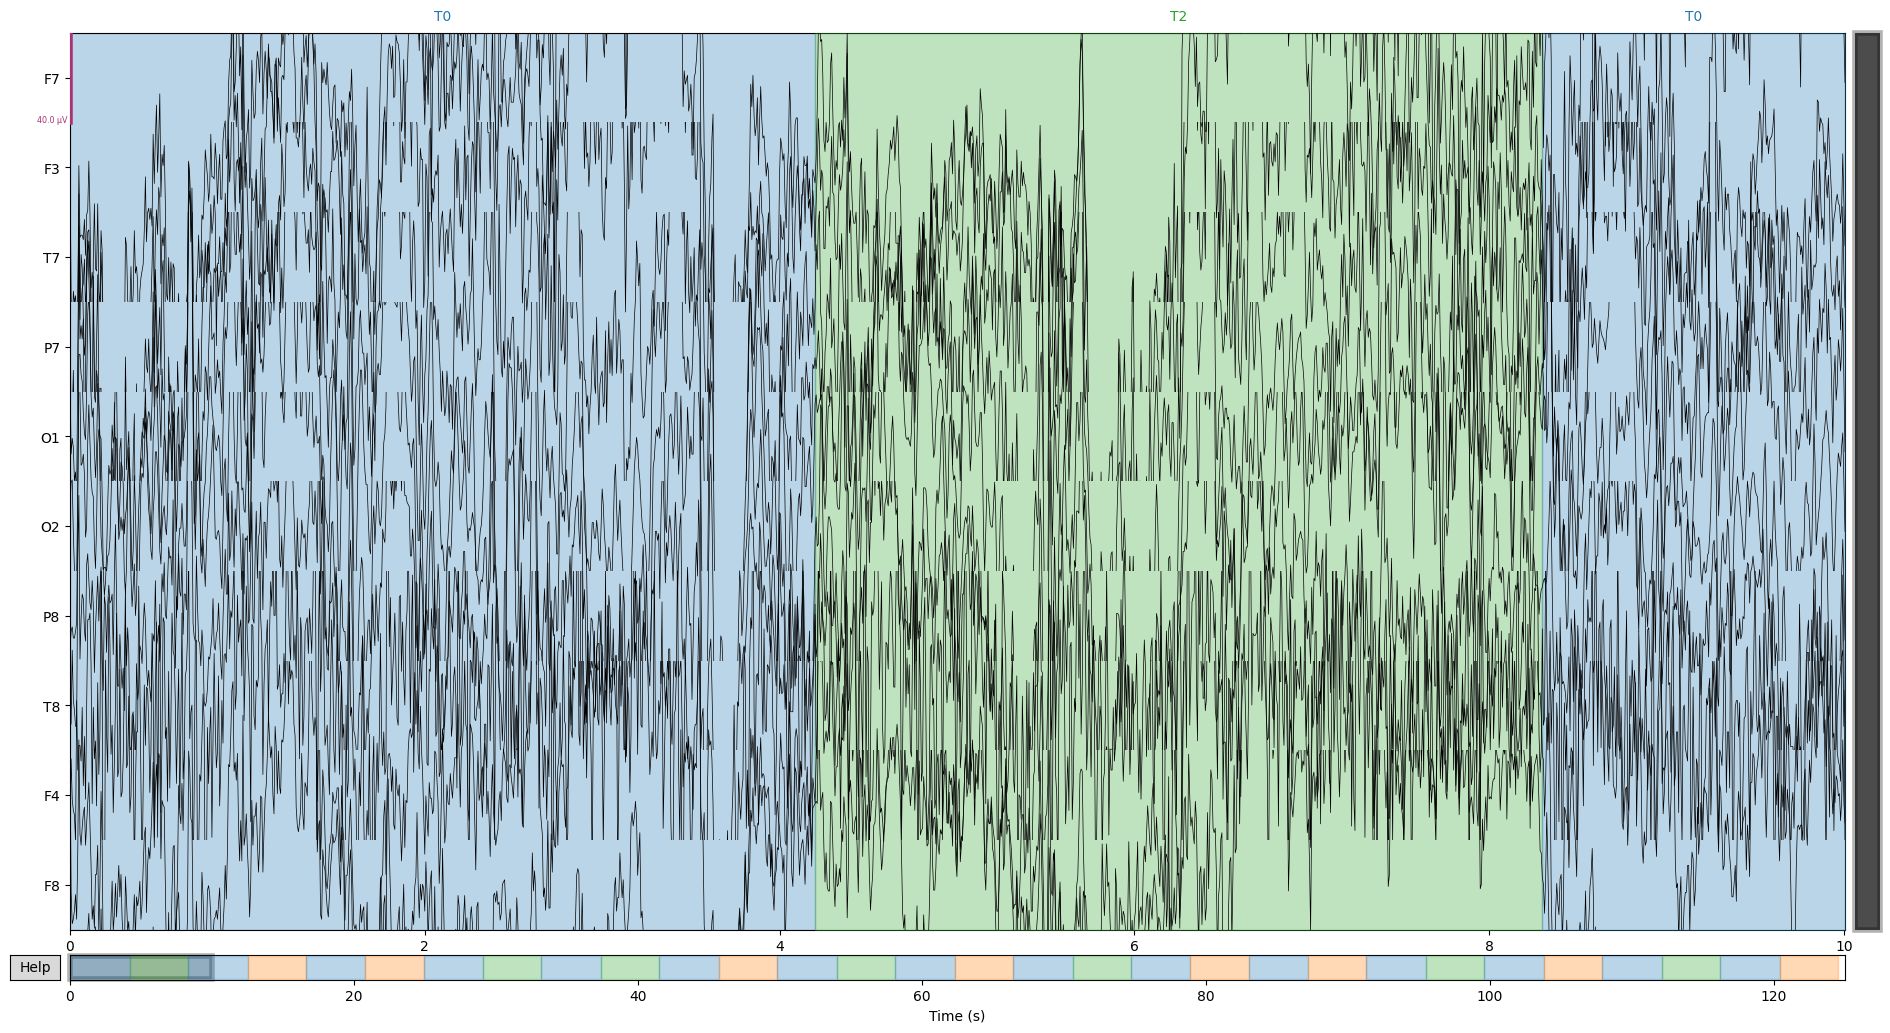

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


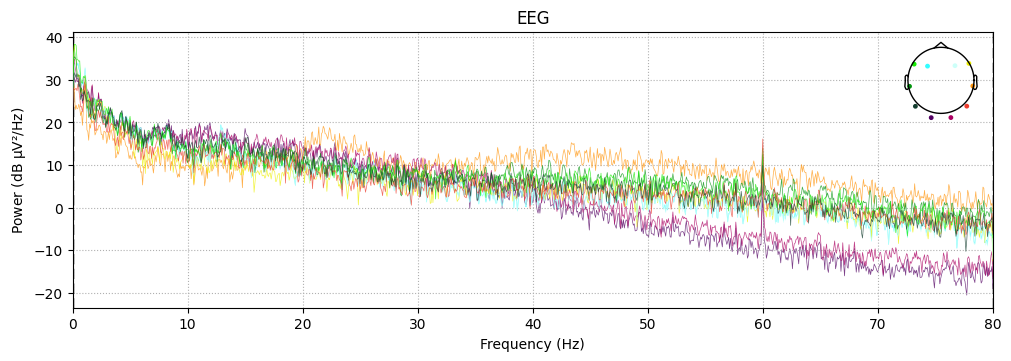

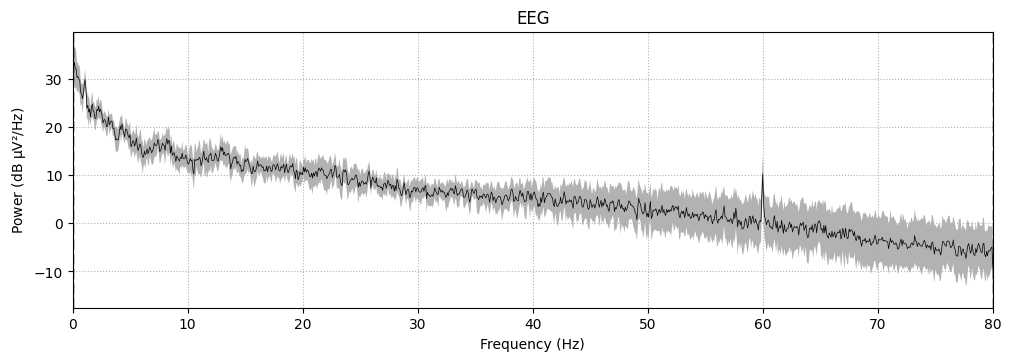

In [28]:
def identify_artifacts(raw_data, desired_channels):
    raw = raw_data

    # plot the original data for each channel
    raw.plot(title="Raw Data for each channel", duration=10, n_channels=len(desired_channels))

    # calculate the power spectral density of the original data and plot it
    # plot the power spectral density of the original data, excluding bad channels and limiting the frequency to 80 Hz because the data is sampled at 160 Hz
    raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False)

    # plot the average power spectral density of the original data, excluding bad channels and limiting the frequency to 80 Hz because the data is sampled at 160 Hz and averaging over all channels
    raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False, average=True)

    plt.show()

    # we can in the psd plot that there is a huge artifact in the data at 60 Hz
    # the 60 Hz artifact (lion noise) is most likely caused by the power line noise (50Hz = Europe, 60Hz = US)
    # we can also see that the data is not clean and there are other artifacts present

identify_artifacts(raw, desired_channels)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (33.006 s)

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


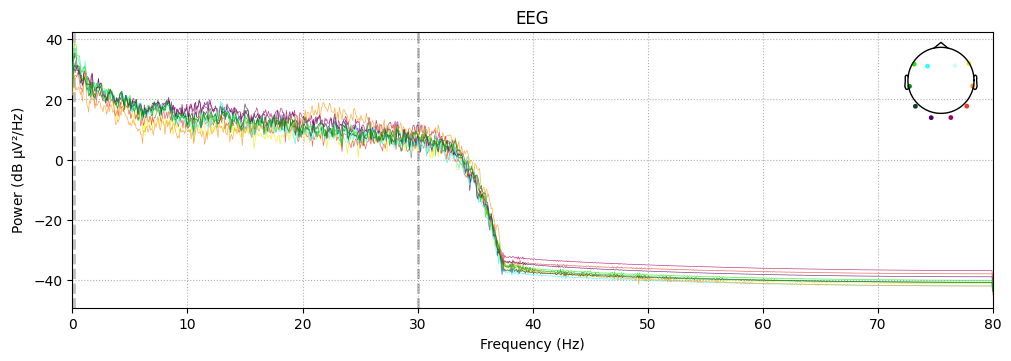

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


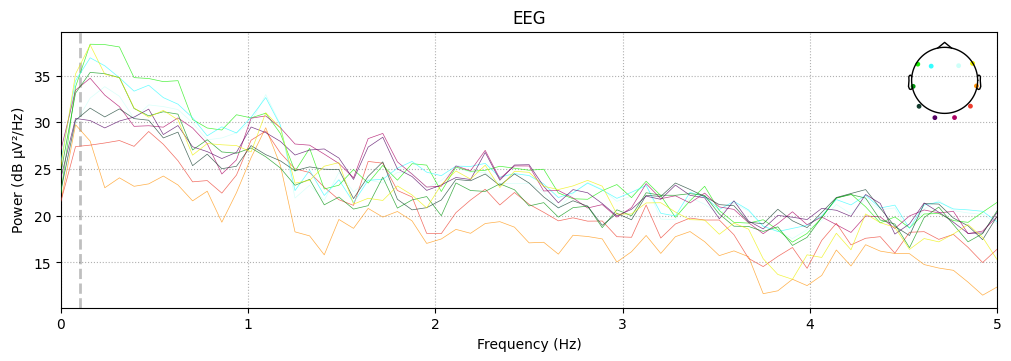

In [37]:
# Filter settings
low_cut = 0.1
hi_cut  = 30

raw_filt = raw.copy().filter(low_cut, hi_cut)

raw_filt.compute_psd().plot()
plt.show()
raw_filt.compute_psd(fmax=5).plot()
plt.show()

unipolar artefacts = https://pressrelease.brainproducts.com/eeg-artifacts-handling-in-analyzer/

bipolar artefacts = https://www.learningeeg.com/artifacts#w-tabs-0-data-w-pane-1

the example dataset uses unipolar EEG data, which means that the reference is the same for all channels

In [29]:
# Filter settings
ica_low_cut = 1.0 # For ICA, we filter out more low-frequency power
hi_cut  = 30

raw_ica = raw.copy().filter(ica_low_cut, hi_cut)

# Break raw data into 1 s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 125 events and 161 original time points ...
1 bad epochs dropped


In [30]:
from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs_ica)

reject_log = ar.get_reject_log(epochs_ica)

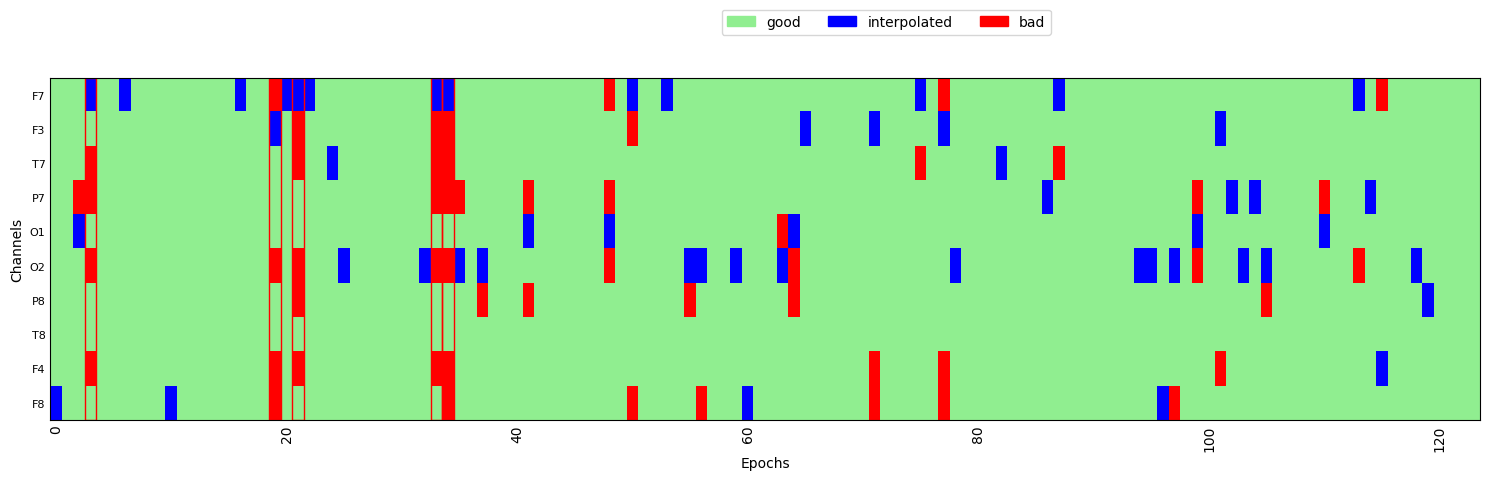

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[15, 5])
reject_log.plot('horizontal', ax=ax, aspect='auto')
plt.show()

In [32]:
# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by explained variance: 8 components
Fitting ICA took 0.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,18 iterations on epochs (6426 samples)
ICA components,8
Available PCA components,10
Channel types,eeg
ICA components marked for exclusion,—


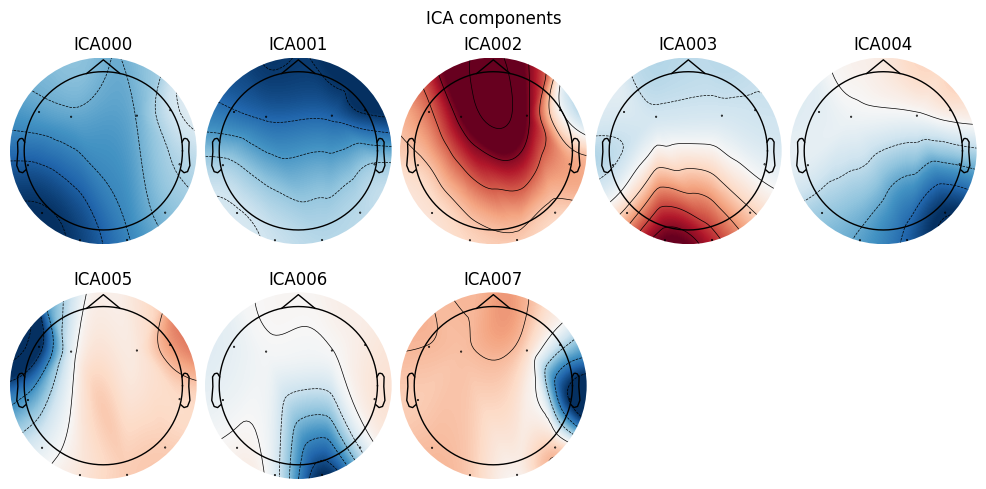

In [33]:
ica.plot_components();

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated


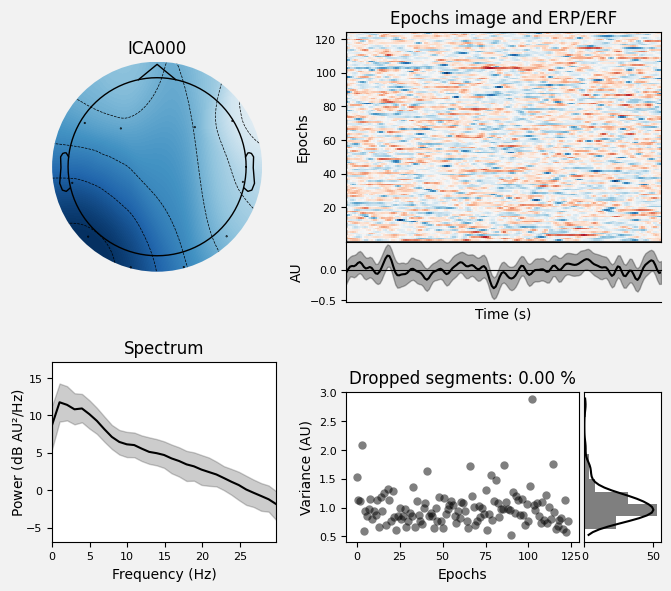

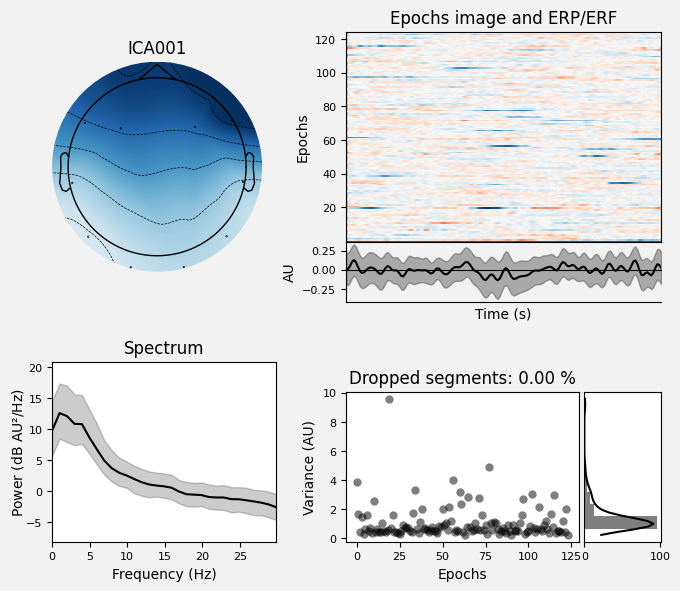

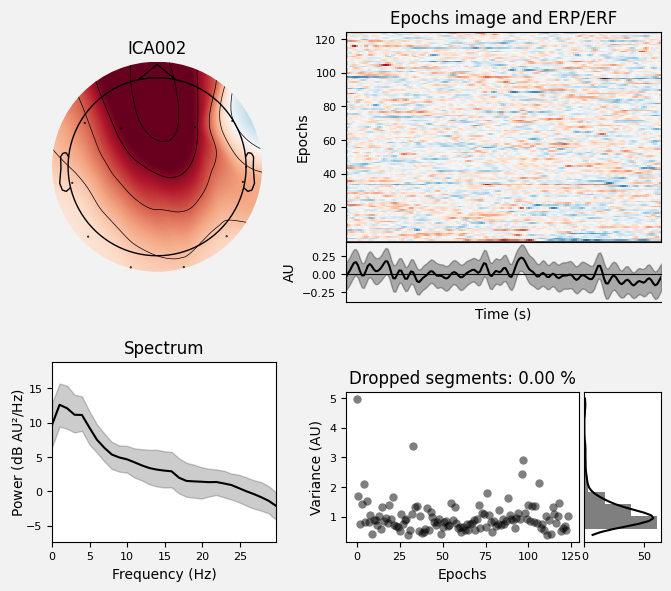

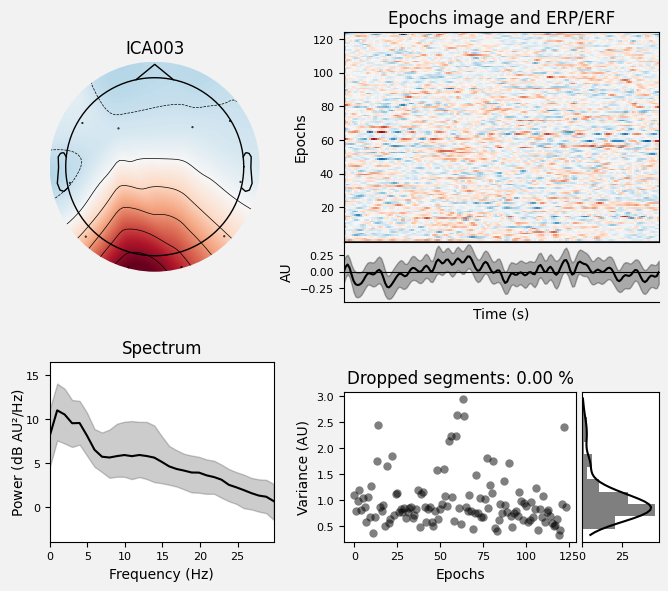

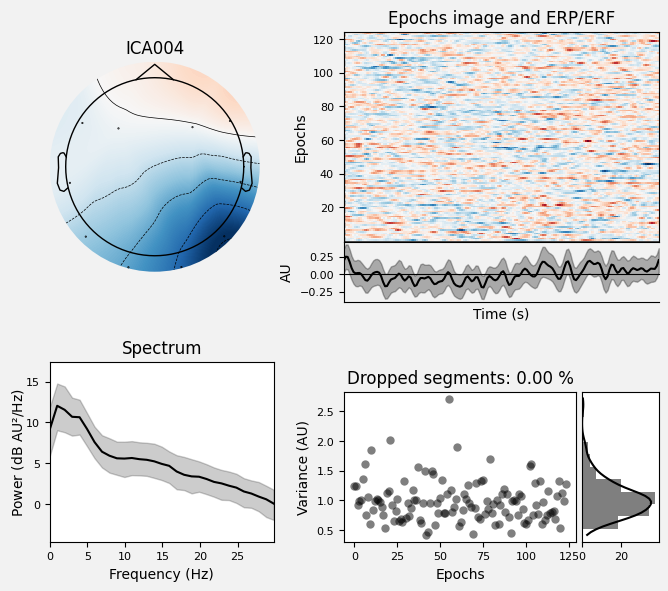

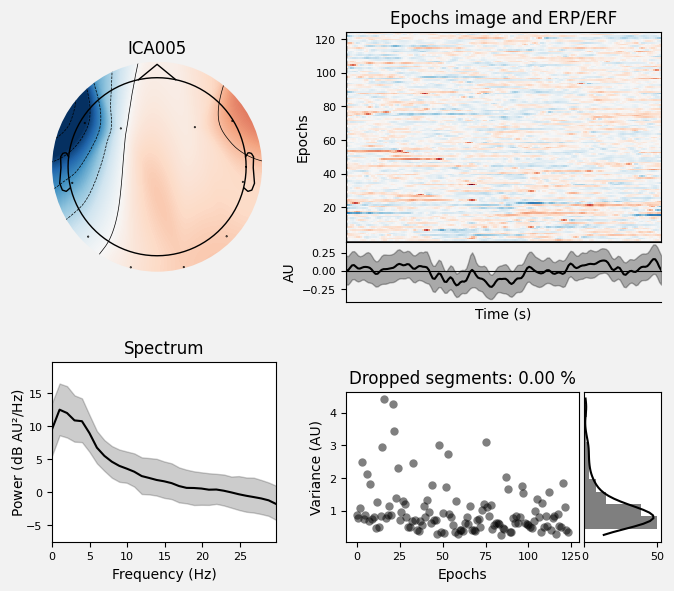

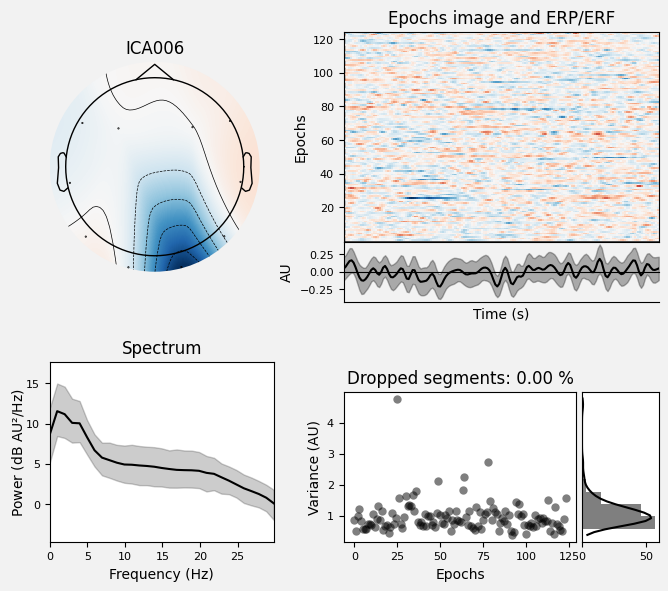

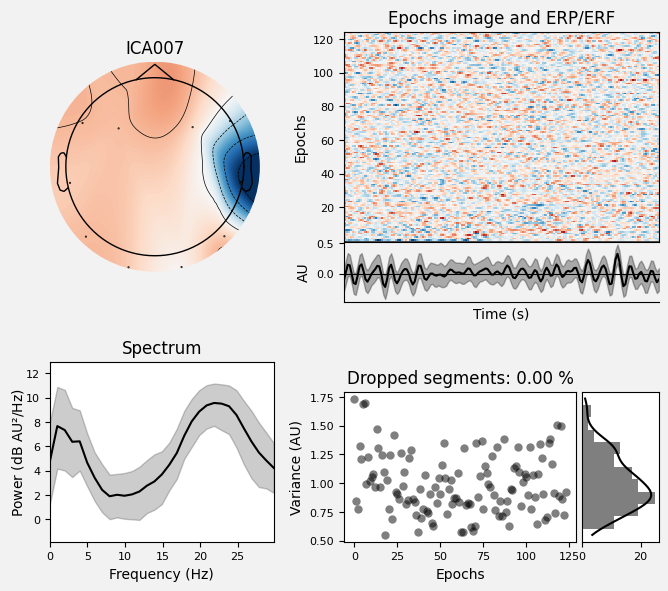

In [34]:
ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': hi_cut});